In [65]:
"""
Generating data

"""

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
from npl import bootstrap_logreg as bbl
import pickle

import seaborn as sns
import importlib
from npl.evaluate import logreg_ll as lrl



n_iter=5

def gen_toy(N_data, beta, intercept=2, seed=100):
    #def run_HDP_NPL(datasets, method, alpha, beta, params):
    #run_HDP_NPL([d1, d2, d3], method=‘RandomForest’, alpha=0.1, gamma=2., params={num_trees: 3, tree_depth: 5})
    #run_HDP_NPL([d1, d2, d3,d4], method=‘LogisticRegression’, alpha=0.1, gamma=2., params={regularizer:None})
    
    np.random.seed(seed)
    
    K_set=len(N_data)
    X=[]
    
    for ss in range(K_set):
        X.append(np.random.multivariate_normal(beta[ss], [[1,0],[0,1]], N_data[ss]))
    
    Linear_part=[]
    eta=[]
    y=[]
    
    for i in range(K_set):
        Linear_part.append(X[i]@beta[i]+intercept*np.ones(N_data[i]))
        eta.append(1/(1 + np.exp(-Linear_part[i])))
        y.append(np.random.binomial(1,eta[i]))
    
    gamma=[1/b for b in N_data ]
    
    return X, y, gamma


def gen_test_toy(N_test_data, beta, intercept=2, seed=100):
    #def run_HDP_NPL(datasets, method, alpha, beta, params):
    #run_HDP_NPL([d1, d2, d3], method=‘RandomForest’, alpha=0.1, gamma=2., params={num_trees: 3, tree_depth: 5})
    #run_HDP_NPL([d1, d2, d3,d4], method=‘LogisticRegression’, alpha=0.1, gamma=2., params={regularizer:None})
    
    np.random.seed(seed+10101)
    
    K_set=len(N_test_data)
    
    X=[]
    
    for i in range(K_set):
        X.append(np.random.multivariate_normal(beta[i], [[1,0],[0,1]], N_test_data[i]))
        
    Linear_part=[]
    eta=[]
    y=[]
    
    for i in range(K_set):
        Linear_part.append(X[i]@beta[i]+intercept*np.ones(N_test_data[i]))
        eta.append(1/(1 + np.exp(-Linear_part[i])))
        y.append(np.random.binomial(1,eta[i]))
    
    gamma=[1/b for b in N_test_data ]
    
    return X, y, gamma



    

In [47]:
def main(beta, intercept, B_postsamples):
    

    T_trunc = 100
    a=1
    b = 1 #rate of gamma hyperprior
    
    alph_conc=0 # D ~ DP(alpha_conc, H)
    alpha_top_layer=0 # Dk ~ DP(alpha_top_layer, D)
    N_data=[1000,2000,5000]
    D_data=len(beta[0])
    
    K_set=len(beta)
    
    
    for i in range(n_iter):

        seed = 100+i
        
        np.random.seed(seed)
        x, y, gamma = gen_toy(N_data, beta, intercept, seed)
        
        #y,x,alph_conc,gamma,N_data,D_data = load_data(dataset,seed)

        start= time.time()
        #carry out posterior bootstrap
        temp = bbl.bootstrap_logreg(B_postsamples,alph_conc,alpha_top_layer,T_trunc,y,x,N_data,D_data,a,b,gamma)
        end = time.time()
        print ('Time elapsed = {}'.format(end - start))
        
        
        
        beta_bb=[]
        ll_bb=[]
        
        for j in range(K_set):
            beta_b=np.zeros((B_postsamples,K_set))
            ll_b=[]
            for bb in range(B_postsamples):
                beta_b[bb]=temp[j][bb][0]
                ll_b.append(temp[j][bb][1])
            beta_bb.append(beta_b)
            ll_bb.append(ll_b)
        
        

        #convert to dataframe and save
        dict_bb = {'beta': beta_bb, 'll': ll_bb, 'time': end-start}
        par_bb = pd.Series(data = dict_bb)
        print(par_bb['time'])
        
        par_bb.to_pickle('./parameters/par_bb_logreg_c{}_a{}_b{}_gN_pol_B{}_seed{}'.format(alph_conc,a,b,B_postsamples,seed))


if __name__=='__main__':
    main([np.array([-1,1]),np.array([-1,1]),np.array([-1,1])],2,1000)
    #main([np.array([1,5]),np.array([-1,7]),np.array([9,-1])],2,1000)
    
    
    
    
    
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Time elapsed = 2.378098964691162
2.378098964691162


  0%|          | 0/1000 [00:00<?, ?it/s]

Time elapsed = 2.659559965133667
2.659559965133667


  0%|          | 0/1000 [00:00<?, ?it/s]

Time elapsed = 2.40000581741333
2.40000581741333


  0%|          | 0/1000 [00:00<?, ?it/s]

Time elapsed = 2.645625114440918
2.645625114440918


100%|██████████| 1000/1000 [00:00<00:00, 2524.31it/s]


Time elapsed = 2.3597629070281982
2.3597629070281982


In [48]:
X_test, y_test, _=gen_test_toy([1000,1000,1000], [np.array([0,0]),np.array([-1,1]),np.array([1,-1])],2,12121)

In [49]:
def eval(x_test, y_test, N_test):
    #par=dataset
    #Load test data
    K_set=len(y_test)
    
    
    lppd = np.zeros([n_iter,K_set])
    mse = np.zeros([n_iter,K_set])
    predcor = np.zeros([n_iter,K_set])
    time = np.zeros([n_iter,K_set])
    card = np.zeros([n_iter,K_set])
    
    
    D,c,eps = 2, 0, 1e-1
    
    
    

    for i in range(n_iter):
        par = pd.read_pickle('./parameters/par_bb_logreg_c{}_a{}_b{}_gN_pol_B1000_seed{}'.format(0,1,1,100+i))
        #Run through each seed to calculate predictive performance/times
        #seed = 100+i
        #y_test,x_test,N_test,D,c,pref,eps = load_data(dataset,seed)
        BETA=[]
        ALPHA=[]
        time[i]=par['time']
        for j in range(K_set):
            BETA.append( par['beta'][j][:,0:2])
            ALPHA.append(par['beta'][j][:,2])
            
            lppd[i,j]=lrl.lppd(y_test[j],x_test[j],BETA[j],ALPHA[j])
            mse[i,j]=lrl.MSE(y_test[j],x_test[j],BETA[j],ALPHA[j])
            predcor[i,j]= lrl.predcorrect(y_test[j],x_test[j],BETA[j],ALPHA[j])
            mean_beta = np.mean(BETA[j],axis = 0)
            card[i,j] = lrl.checkcard([mean_beta],eps)
        
        
    #dict = {'lppd_1':lppd[0]/N_test[0], 'mse_1':mse[0], 'predcor_1': 100*predcor[0], 'card_1': ((D-card[0])/D)*100, 'time':time }

    for j in range(K_set):
        print('FOR DATASET')
        print(j)
        
        print('lppd')
        print(np.mean(lppd[:,j]/N_test[j]))
        print(np.std(lppd[:,j]/N_test[j]))
        
        #import pdb
        #pdb.set_trace()

        print('mse')
        print(np.mean(mse[:,j]))
        print(np.std(mse[:,j]))

        print('pa')
        print(np.mean(100*predcor[:,j]))
        print(np.std(100*predcor[:,j]))

    
        print('time')
        print(np.mean(time))
        print(np.std(time))
        
        print("\n")
        print("\n")
        
        


#Run for 3 datasets from paper
def main():
    eval(X_test,y_test,[1000,1000,1000])

if __name__=='__main__':
    main()

FOR DATASET
0
lppd
-0.6650895454915307
0.05650164092482095
mse
0.20263469009101268
0.022958976026457675
pa
70.82
4.401545183228272
time
2.488610553741455
0.13456790122813886




FOR DATASET
1
lppd
-0.1485502598790991
0.020350175600648553
mse
0.035604677996240695
0.0024457002705552
pa
95.94
0.372021504754769
time
2.488610553741455
0.13456790122813886




FOR DATASET
2
lppd
-1.0593411217930504
0.12572986695639354
mse
0.3731766824974453
0.040789420825215174
pa
41.64
5.590921212108075
time
2.488610553741455
0.13456790122813886






In [50]:
par = pd.read_pickle('./parameters/par_bb_logreg_c{}_a{}_b{}_gN_pol_B1000_seed{}'.format(0,1,1,100))

In [51]:
beta_2=par["beta"]

In [62]:
np.mean(beta_2[2],axis=0)

array([-1.0636803 ,  0.984319  ,  1.91759226])

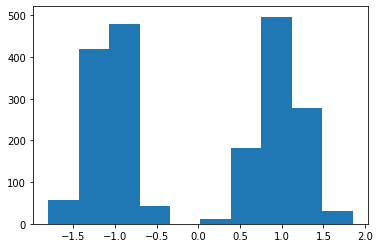

In [63]:
plt.hist(beta_2[2][:,0:2].flatten())
plt.show()

In [34]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [66]:

N_data=[100,200,500]
X, y, gamma,eta = gen_toy(N_data, [np.array([-1,1]),np.array([-1,1]),np.array([-1,1])],2, 100)

In [72]:
[np.sum(yy) for yy in y]

[97, 195, 476]

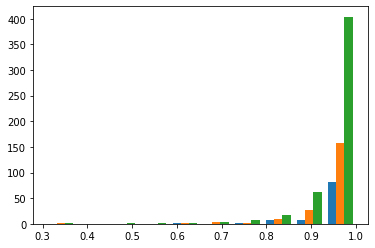

In [73]:
plt.hist(eta)
plt.show()

In [38]:
clf = LogisticRegression(random_state=0).fit(X[1], y[1])
clf.intercept_

array([2.74043387])

In [39]:
clf.coef_

array([[-1.36914489,  1.09171756]])

In [ ]:
model=sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)[source]





In [15]:
import numpy as np
import pandas as pd
from scipy.io import arff
import random
import pickle
from sklearn.model_selection import train_test_split

def adult_load(seed):
    np.random.seed(seed)

    #import
    ad_train = pd.read_csv('./data/adult.data',header = None)
    #import pdb
    #pdb.set_trace()
    ad_test = pd.read_csv('./data/adult.test', header = None)

    #convert missing data to Nans
    ad_train[ad_train == ' ?']= np.nan
    ad_test[ad_test == ' ?']= np.nan

    #drop missing categorical data
    ad_train.dropna(axis = 0,inplace = True)
    ad_test.dropna(axis = 0,inplace = True)

    #separate covariates from classes
    N_train = np.shape(ad_train)[0]
    y_train = np.zeros(N_train)
    y_train[ad_train.iloc[:,14] == ' >50K']=1
    x_train = ad_train.iloc[:,0:14]

    N_test = np.shape(ad_test)[0]
    y_test = np.zeros(N_test)
    y_test[ad_test.iloc[:,14] == ' >50K.']=1
    x_test = ad_test.iloc[:,0:14]

    #setup dummy
    x_train =pd.get_dummies(x_train,drop_first = True,columns = [1,3,5,6,7,8,9,13])
    x_test = pd.get_dummies(x_test,drop_first = True,columns = [1,3,5,6,7,8,9,13])    

    #fix dummy difference
    missing_cols = set( x_train.columns ) - set( x_test.columns)
    for c in missing_cols:
        x_test[c] = 0
    x_test = x_test[x_train.columns]

    D = np.shape(x_train)[1]
    colnames = list(x_train.columns.values)

    #concatenate and resplit
    x = np.concatenate((x_train,x_test),axis = 0)
    y = np.concatenate((y_train,y_test))
    x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.2, stratify = y)
    x_train = pd.DataFrame(x_train,columns = colnames)
    x_test = pd.DataFrame(x_test, columns = colnames)
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    N_train = np.shape(x_train)[0]
    N_test = np.shape(x_test)[0]

    #normalize by mean and std for non dummy variables
    mean_train = x_train.mean(axis = 0)
    std_train = x_train.std(axis = 0)
    x_train[[0,2,4,10,11,12]] -= mean_train
    x_train[[0,2,4,10,11,12]] /= std_train

    mean_test = x_test[[0,2,4,10,11,12]].mean(axis = 0)
    std_test = x_test[[0,2,4,10,11,12]].std(axis = 0)
    x_test[[0,2,4,10,11,12]] -= mean_test
    x_test[[0,2,4,10,11,12]] /= std_test

    #convert binarys to uint8 to save space
    y_train = y_train.astype('uint8')    
    y_test = y_test.astype('uint8')

    colnames2 = set(colnames) - set([0,2,4,10,11,12])
    x_train[list(colnames2)] = x_train[list(colnames2)].astype('uint8') 
    x_test[list(colnames2)] = x_test[list(colnames2)].astype('uint8') 

    #Put into dictionary and save
    ad_data_train= {'y': y_train, 'x': x_train, 'N':N_train,'D':D}
    ad_data_test= {'y': y_test, 'x': x_test, 'N':N_test,'D':D}

    with open('./data/ad_train_seed{}'.format(seed), 'wb') as handle:
        pickle.dump(ad_data_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('./data/ad_test_seed{}'.format(seed), 'wb') as handle:
        pickle.dump(ad_data_test, handle, protocol=pickle.HIGHEST_PROTOCOL)



for i in range(30):
    adult_load(100+i)
  

/Users/cuifuheng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/Users/cuifuheng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/Users/cuifuheng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/Users/cuifuheng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
"""
main script for running NPL

"""

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
from npl import bootstrap_logreg as bbl
import pickle

n_iter=1

def load_data(seed):
    #load adult
    if True:
        with open('./data/ad_train_seed{}'.format(seed), 'rb') as handle:
            ad_train = pickle.load(handle)

        #Move into vectors
        y = np.uint8(ad_train['y'])[:,0]
        x = ad_train['x'].values
        D_data = ad_train['D']
        N_data = ad_train['N']
  

        #prior and loss settings from paper
        alph_conc = 0 
        gamma = 1/N_data


    return y,x,alph_conc,gamma,N_data,D_data



def main(B_postsamples):
    #same parameters between datasets
    T_trunc = 100
    a=1
    b = 1 #rate of gamma hyperprior
    for i in range(n_iter):

        seed = 100+i
        np.random.seed(seed)
        y,x,alph_conc,gamma,N_data,D_data = load_data(seed)

        start= time.time()
        #carry out posterior bootstrap
        beta_bb, ll_b = bbl.bootstrap_logreg(B_postsamples,alph_conc,T_trunc,y,x,N_data,D_data,a,b,gamma)
        end = time.time()
        print ('Time elapsed = {}'.format(end - start))

        #convert to dataframe and save
        dict_bb = {'beta': beta_bb, 'll_b': ll_b, 'time': end-start}
        par_bb = pd.Series(data = dict_bb)

        
        if True:
            par_bb.to_pickle('./parameters/par_bb_logreg_c{}_a{}_b{}_gN_ad_B{}_seed{}'.format(alph_conc,a,b,B_postsamples,seed))

        

if __name__=='__main__':
    main(200)







100%|██████████| 12/12 [00:00<00:00, 49.85it/s]

100%|██████████| 12/12 [00:00<00:00, 3262.78it/s]

Time elapsed = 44.20330095291138




100%|██████████| 12/12 [00:00<00:00, 3557.51it/s]

Time elapsed = 46.408413887023926


Time elapsed = 44.87112808227539
